# ポートフォリオ

## このファイルについて
このファイルは私が春にした学習をまとめたものである。

単回帰分析、重回帰分析、決定木、ランダムフォレストにより「不動産の価格を予測する」モデルの作成と可視化を行った。

データをトレーニングデータとテストデータ（7:3）に分割しテストデータにおいてモデルを検証した。

目標：「80％以上の予測精度のモデルを作成すること」

結果：最も高精度だったランダムフォレストを使用したモデルにおいても7割を下回ってしまった。

原因：

・データ数が少ない

・自分の技術不足
→より高精度なモデルを作成できる分析手法があったのではないか。

In [334]:
#基本モジュールのインポート
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model

In [378]:
#分析するデータフレームの読み込み
df = pd.read_csv("house.csv")
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,yr_renovated
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,3,7,1955,0
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,3,7,1951,1991
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,3,6,1933,0
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,5,7,1965,0
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,3,8,1987,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,20140508T000000,307000.0,3,1.75,1890,13860,1.0,5,7,1966,0
1996,20141105T000000,194000.0,3,1.50,1010,5000,1.0,3,6,1943,0
1997,20141114T000000,180000.0,3,1.00,1010,8581,1.0,4,6,1920,0
1998,20140718T000000,465000.0,4,2.25,2340,13383,1.0,3,8,1983,0


# 今回扱うデータそれぞれの名前
- Id - 物件のID
- price - 価格
- bedrooms - べットルーム数
- bathrooms - お風呂数
- sqft_living - 住宅部分面積
- sqft_lot - 敷地面積
- floors - フロア数
- waterfront - 海岸の土地か否か
- view - 眺めの良さ
- condition - 状態
- grade - 住宅部門に与えられた格付け 
- y_built - 建築された年
- yr_renovated - 家が改装された年

In [379]:
#データの先頭を確認
df.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,yr_renovated
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,3,7,1955,0
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,3,7,1951,1991
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,3,6,1933,0


In [380]:
#データの末尾を確認
df.tail(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,yr_renovated
1995,20140508T000000,307000.0,3,1.75,1890,13860,1.0,5,7,1966,0
1996,20141105T000000,194000.0,3,1.50,1010,5000,1.0,3,6,1943,0
1997,20141114T000000,180000.0,3,1.00,1010,8581,1.0,4,6,1920,0
1998,20140718T000000,465000.0,4,2.25,2340,13383,1.0,3,8,1983,0
1999,20150124T000000,650000.0,4,3.00,2950,5000,2.0,3,9,1979,0


In [416]:
#欠損値の確認
df.isnull().sum()

date            0
price           0
bedrooms        0
bathrooms       0
sqft_living     0
sqft_lot        0
floors          0
condition       0
grade           0
yr_built        0
yr_renovated    0
dtype: int64

In [381]:
#テストデータとトレーニングデータに分割
#ランダムサンプリング
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,test_size=0.3,train_size=0.7)
print(df_train)

                 date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
1721  20141118T000000   360400.0         3       2.50         1630     11592   
823   20141002T000000   287500.0         3       1.00         1810      7200   
1729  20140514T000000   620000.0         5       2.50         2540      3832   
18    20141205T000000   189000.0         2       1.00         1200      9850   
691   20140923T000000  1480000.0         5       2.50         4570     19252   
...               ...        ...       ...        ...          ...       ...   
855   20140812T000000   370500.0         4       2.50         1790      6120   
1958  20150227T000000   429800.0         3       2.00         1970      7000   
1428  20150128T000000   914600.0         4       3.00         3180     80837   
1730  20141120T000000  1680000.0         5       4.25         4830     11466   
1442  20141107T000000   352950.0         3       1.00         1760      3000   

      floors  condition  grade  yr_buil

In [382]:
#df全体の相関係数を確認
corr_mat = df.corr(method='pearson')
corr_mat

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,yr_renovated
price,1.000000,0.307547,0.515653,0.694428,0.073059,0.269801,0.056120,0.631818,0.037456,0.110459
bedrooms,0.307547,1.000000,0.546214,0.575976,0.032098,0.226438,0.014368,0.386047,0.160793,0.035034
bathrooms,0.515653,0.546214,1.000000,0.759317,0.036908,0.491835,-0.088908,0.666385,0.481295,0.033873
sqft_living,0.694428,0.575976,0.759317,1.000000,0.100878,0.394983,-0.033627,0.771950,0.321180,0.040541
sqft_lot,0.073059,0.032098,0.036908,0.100878,1.000000,-0.007025,-0.000748,0.053911,0.038549,-0.005696
floors,0.269801,0.226438,0.491835,0.394983,-0.007025,1.000000,-0.221272,0.466283,0.406848,0.029211
condition,0.056120,0.014368,-0.088908,-0.033627,-0.000748,-0.221272,1.000000,-0.106342,-0.308045,-0.089060
grade,0.631818,0.386047,0.666385,0.771950,0.053911,0.466283,-0.106342,1.000000,0.431562,0.002952
yr_built,0.037456,0.160793,0.481295,0.321180,0.038549,0.406848,-0.308045,0.431562,1.000000,-0.248820
yr_renovated,0.110459,0.035034,0.033873,0.040541,-0.005696,0.029211,-0.089060,0.002952,-0.248820,1.000000


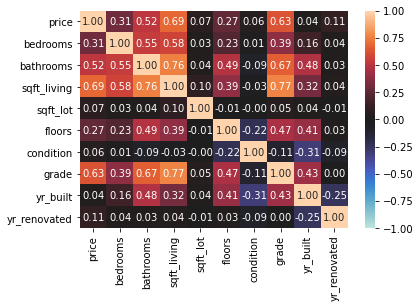

In [383]:
#元データの相関係数ヒートマップ
sns.heatmap(corr_mat,
            vmin=-1.0, #最小値
            vmax=1.0, #最大値
            center=0, #中央値
            annot=True, # True:格子の中に値を表示
            fmt='.2f', #書式設定
            xticklabels=corr_mat.columns.values, #X軸ラベル
            yticklabels=corr_mat.columns.values #Y軸ラベル
           )
plt.show()

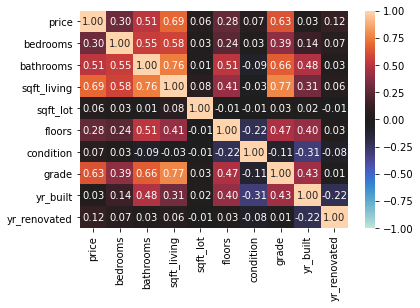

In [385]:
#トレーニングデータのヒートマップ

corr_mat2 = df_train.corr(method='pearson')
sns.heatmap(corr_mat2,
            vmin=-1.0, #最小値
            vmax=1.0, #最大値
            center=0, #中央値
            annot=True, # True:格子の中に値を表示
            fmt='.2f', #書式設定
            xticklabels=corr_mat.columns.values, #X軸ラベル
            yticklabels=corr_mat.columns.values #Y軸ラベル
           )
plt.show()

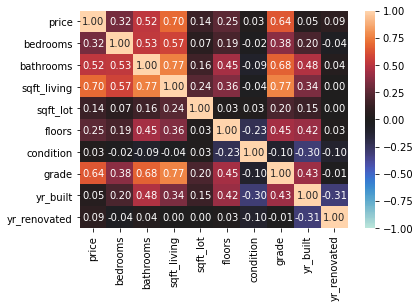

In [418]:
#テストデータのヒートマップ
corr_mat3 = df_test.corr(method='pearson')
sns.heatmap(corr_mat3,
            vmin=-1.0, #最小値
            vmax=1.0, #最大値
            center=0, #中央値
            annot=True, # True:格子の中に値を表示
            fmt='.2f', #書式設定
            xticklabels=corr_mat.columns.values, #X軸ラベル
            yticklabels=corr_mat.columns.values #Y軸ラベル
           )
plt.show()

# ①単回帰分析

In [396]:
#priceと相関の高い変数はなにか
step1 = corr_mat.iloc[1:,0]
print(step1)
print("-"*100)

step2 = abs(step1)
print(step2)
print("-"*100)

step3_name = step2.index[np.argmax(step2)]
step3_val = step1[np.argmax(step2)]

print("priceとの相関が最大となる変数は",step3_name,"で、相関係数は",step3_val)
print("-"*100)

bedrooms        0.307547
bathrooms       0.515653
sqft_living     0.694428
sqft_lot        0.073059
floors          0.269801
condition       0.056120
grade           0.631818
yr_built        0.037456
yr_renovated    0.110459
Name: price, dtype: float64
----------------------------------------------------------------------------------------------------
bedrooms        0.307547
bathrooms       0.515653
sqft_living     0.694428
sqft_lot        0.073059
floors          0.269801
condition       0.056120
grade           0.631818
yr_built        0.037456
yr_renovated    0.110459
Name: price, dtype: float64
----------------------------------------------------------------------------------------------------
priceとの相関が最大となる変数は sqft_living で、相関係数は 0.6944284671836237
----------------------------------------------------------------------------------------------------


In [397]:
#モデル作成に使う関数
reg = linear_model.LinearRegression()
#目的変数と説明変数の指定
X_train_1 = df_train[['sqft_living']]
y_train_1 = df_train[['price']]

X_test_1 = df_test[['sqft_living']]
y_test_1 = df_test[['price']]

In [398]:
reg.fit(X_train_1,y_train_1)

LinearRegression()

In [399]:
print('回帰係数は',reg.coef_) 
print('切片は',reg.intercept_)

回帰係数は [[288.4937459]]
切片は [-66900.06540216]


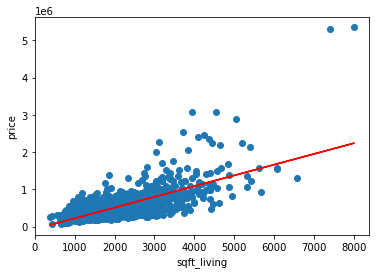

In [400]:
#可視化
plt.scatter(df_train['sqft_living'],df_train['price'])
plt.xlabel('sqft_living')
plt.ylabel('price')

plt.plot(X_train_1,reg.predict(X_train_1),c='r')

In [401]:
#決定係数
reg.score(X_train_1,y_train_1)

0.4810970864741999

In [402]:
#予測精度の検証
from sklearn.metrics import r2_score

y_train_1_pred = reg.predict(X_train_1)
y_test_1_pred = reg.predict(X_test_1)

print ('R^2 train: %.3f, test: %.3f' %(r2_score(y_train_1,y_train_1_pred),
                                       r2_score(y_test_1,y_test_1_pred)))

R^2 train: 0.481, test: 0.484


# ②重回帰分析
5パターンほど試して最も予測精度がよかったものを載せています

In [403]:
#それぞれの説明変数と目的変数の相関係数
#この相関係数が1に近いものを選んで分析に使う
corr_mat[['price']]

,price
price,1.000000
bedrooms,0.307547
bathrooms,0.515653
sqft_living,0.694428
sqft_lot,0.073059
floors,0.269801
condition,0.056120
grade,0.631818
yr_built,0.037456
yr_renovated,0.110459


In [404]:
#目的変数と説明変数の指定
X_train_2 = df_train[['bedrooms','bathrooms','sqft_living','condition','grade','yr_built']]
y_train_2 = df_train[['price']]

X_test_2 = df_test[['bedrooms','bathrooms','sqft_living','condition','grade','yr_built']]
y_test_2 = df_test[['price']]

## 今回はデータの粒度に差があったので正規化を行いました

In [405]:
#numpyを用いて正規化
import numpy as np

X_train_2_np = X_train_2.apply(lambda X_train_2: (X_train_2 - np.mean(X_train_2)) / np.std(X_train_2))
y_train_2_np = y_train_2.apply(lambda X_train_2: (X_train_2 - np.mean(X_train_2)) / np.std(X_train_2))

print(X_train_2_np.head(5))
print(y_train_2_np.head(5))

      bedrooms  bathrooms  sqft_living  condition     grade  yr_built
1721 -0.401509   0.576991    -0.477427  -0.688104  0.335862  0.672017
823  -0.401509  -1.404500    -0.277633   0.760536 -0.506803 -0.501391
1729  1.855971   0.576991     0.532642   2.209176  0.335862 -1.390336
18   -1.530249  -1.404500    -0.954712   0.760536 -0.506803 -1.674799
691   1.855971   0.576991     2.785872   2.209176  2.021192 -0.110255
         price
1721 -0.445753
823  -0.640297
1729  0.247025
18   -0.903157
691   2.542053


In [406]:
#正規化されたx2のデータそれぞれの平均値
X_train_2_np.mean()

bedrooms      -6.256900e-17
bathrooms     -3.825511e-16
sqft_living    1.503956e-16
condition     -8.342533e-17
grade          4.191885e-16
yr_built       3.264056e-16
dtype: float64

In [407]:
#正規化されたpriceのデータセットの平均
y_train_2_np.mean()

price    2.874685e-17
dtype: float64

In [408]:
#正規化されたX_train_2のデータそれぞれの標準偏差
X_train_2_np.std()

bedrooms       1.000357
bathrooms      1.000357
sqft_living    1.000357
condition      1.000357
grade          1.000357
yr_built       1.000357
dtype: float64

In [409]:
#正規化されたy2のデータの標準偏差
y_train_2_np.std()

price    1.000357
dtype: float64

In [410]:
#モデルを可視化
import statsmodels.api as sm

model = sm.OLS(y_train_2_np,sm.add_constant(X_train_2_np))
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     329.7
Date:                Mon, 12 Apr 2021   Prob (F-statistic):          4.06e-263
Time:                        21:47:04   Log-Likelihood:                -1367.9
No. Observations:                1400   AIC:                             2750.
Df Residuals:                    1393   BIC:                             2787.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.939e-17      0.017   4.03e-15      

### 回帰分析のサマリの見方

*小数点第3位以下は四捨五入

・Const=ｙの係数

       =6.765e-17
       =18.39-17
       =1.39

・Bathrooms＝bathrooms の係数（偏回帰係数）

・R-squared=決定係数

・Adj. R-squared＝自由度調整済み決定係数

　1.4y= -0.08x1 +0.56x2+ 0.25x3

In [411]:
#正規化を元に戻す
model = sm.OLS(y_train_2, sm.add_constant(X_train_2))
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     329.7
Date:                Mon, 12 Apr 2021   Prob (F-statistic):          4.06e-263
Time:                        21:47:08   Log-Likelihood:                -19335.
No. Observations:                1400   AIC:                         3.868e+04
Df Residuals:                    1393   BIC:                         3.872e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7.352e+06   5.57e+05     13.199      

In [412]:
reg.fit(X_train_2,y_train_2)
reg.score(X_train_2,y_train_2)

0.5867611907414297

In [413]:

y_train_2_pred = reg.predict(X_train_2)
y_test_2_pred = reg.predict(X_test_2)

print ('R^2 train: %.3f, test: %.3f' %(r2_score(y_train_2,y_train_2_pred),
                                       r2_score(y_test_2,y_test_2_pred)))

R^2 train: 0.587, test: 0.576


## 単回帰分析よりは予測精度が向上！
まだ精度が高いとは言えない...

# 決定木分析
今回は決定木の中でも回帰木を用いて分析を行います

In [362]:
#従属変数（使用列）の選択
X_train_3 = df_train[['bedrooms','bathrooms','sqft_living','condition','grade','yr_built']]
 #目的変数名の指定
y_train_3 = df_train[['price']]

X_test_3 = df_test[['bedrooms','bathrooms','sqft_living','condition','grade','yr_built']]
y_test_3 = df_test[['price']]

In [363]:
#ライブラリ・モジュールのインポート
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import graphviz

In [364]:
#モデル作成
#木の深さを指定
tree_reg_model = DecisionTreeRegressor(max_depth=3)
tree_reg_model.fit(X_train_3,y_train_3)
print(tree_reg_model.score(X_train_3,y_train_3))

0.5640887111180131


In [414]:
#モデルの精度
y_train_3_pred = tree_reg_model.predict(X_train_3)
y_test_3_pred = tree_reg_model.predict(X_test_3)

print ('R^2 train: %.3f, test: %.3f' %(r2_score(y_train_3,y_train_3_pred),
                                       r2_score(y_test_3,y_test_3_pred)))

R^2 train: 0.564, test: 0.447


In [366]:
!pip install graphviz

In [367]:
#決定木を画像にするモジュール
!pip install pydotplus
from IPython.display import Image
from graphviz import Digraph

In [368]:
#ライブラリだけインストールしてもモジュールをインポートしないとコードとして使えない
from pydotplus import pydotplus

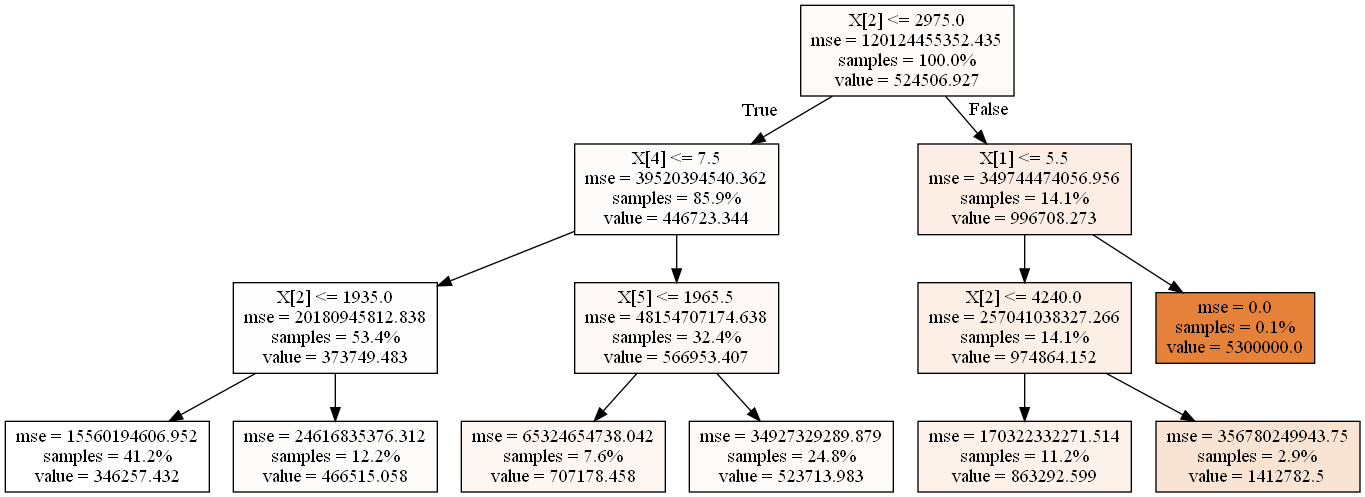

In [369]:
#決定木を使うためのモジュール
from sklearn import tree

dot_data = tree.export_graphviz(
    tree_reg_model,
    out_file=None,
    filled=True,
    proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


x[0]='bedrooms'(ベッドルーム数)​

x[1]='bathrooms'(風呂の数)​

x[2]='sqft_living'(住宅部分面積)​

x[3]='condition'(状態)​

x[4]='grade'(格付け)​

x[5]='yr_built(建てられた年)

MSE：平均二乗誤差 (MSE, Mean Squared Error) とは、実際の値と予測値の絶対値の 2 乗を平均したもの。

Value=モデルにおける予測値

Samples:そのノードに当てはまるデータが全体のうちどれくらいの割合になるか

# ランダムフォレスト

In [370]:
from sklearn.ensemble import RandomForestRegressor

In [371]:
X_train_4 = df_train[['bedrooms','bathrooms','sqft_living','condition','grade','yr_built']]

y_train_4 = df_train[['price']]

X_test_4 = df_test[['bedrooms','bathrooms','sqft_living','condition','grade','yr_built']]
y_test_4 = df_test[['price']]

In [372]:
# ランダムフォレスト回帰オブジェクト生成
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train_4, y_train_4)
rfr.score(X_train_4, y_train_4)

<ipython-input-372-ded28259508b>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train_4, y_train_4)


0.9319780252520329

In [375]:
#予測精度の検証
y_train_4_pred = rfr.predict(X_train_4)
y_test_4_pred = rfr.predict(X_test_4)

print ('R^2 train: %.3f, test: %.3f' %(r2_score(y_train_4,y_train_4_pred),
                                       r2_score(y_test_4,y_test_4_pred)))

R^2 train: 0.932, test: 0.656


## ランダムフォレストを用いたモデルが最も高い精度で予測できた